# Classification Code

The aim of this is to use the normalised college data to train a model that predicts the likelihood of college acceptance, given several factors. Some factors have to do with the student (e.g. GPA, minority), and some have to do with the college (e.g. acceptance rate, private/public). Together, these predictors should fit a model that returns probability of being accepted by a college. 

Load required packages. 

In [1]:
import TIdatabase as ti
%matplotlib inline 
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from matplotlib import rcParams
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn import svm
from sklearn.preprocessing import Imputer
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

### Data Cleaning & Checking

Read the data. 

In [2]:
df = pd.read_csv("collegedata_normalized.csv")
df.head()

,Unnamed: 0,studentID,classrank,admissionstest,AP,averageAP,SATsubject,GPA,GPA_w,program,...,alumni,outofstate,acceptStatus,acceptProb,name,acceptrate,size,public,finAidPct,instatePct
0,0,PWY05BUB4I,NaN,0.926899,7,1.067339,0.324272,-0.187110,0.059947,Biomedical engineering,...,0,0,1,NaN,Rice,0.151,6621,0,0,0
1,1,3UVDFVI9Z0,NaN,0.293054,7,0.660575,-0.440777,0.493474,0.398944,Classics,...,0,1,1,NaN,Rice,0.151,6621,0,0,0
2,2,BCCBHJUP0M,NaN,0.293054,0,NaN,0.324272,0.396247,-1.035273,Biological Science,...,0,1,0,NaN,Rice,0.151,6621,0,0,0
3,3,WZFPWHSQMS,NaN,1.387878,7,0.863957,1.089320,0.104569,-0.383356,Physics,...,0,1,0,NaN,Rice,0.151,6621,0,0,0
4,4,5W1JNQA7G0,NaN,0.408299,1,-0.356334,-0.440777,0.542087,NaN,NaN,...,0,1,1,NaN,Rice,0.151,6621,0,0,0


We now check for NaNs. The code below shows that 23% of all entries are null. This is way too high. 

In [3]:
x = df.isnull().sum(axis=1).tolist()
y = float(sum(x)) / (df.shape[0]*df.shape[1])
print y

0.225931657684


To decrease the proportion of NaNs, we get rid of columns which are almost all null. From the `df.head()` above, we see that either a column is almost all null, or it is almost all non-null. Therefore the 23% above is probably driven mainly by columns that are basically all null. 

So we remove any column that has 50% or more null values. This takes out any predictors that would have been useless anyway. 

In [4]:
cols_to_drop = []
for i in df.columns:
    if 1.0* df[i].isnull().sum() / len(df[i]) >= 0.5:
        cols_to_drop.append(i)
print cols_to_drop
dfr = df.drop(cols_to_drop,axis=1)

['classrank', 'canAfford', 'firstinfamily', 'artist', 'workexp', 'visited', 'acceptProb']


Now drop all columns where the accept status is NaN. 

In [5]:
dfr = dfr[pd.notnull(df["acceptStatus"])]

In [6]:
x = dfr.isnull().sum(axis=1).tolist()
y = float(sum(x)) / (dfr.shape[0]*dfr.shape[1])
print y

0.0304018831218


Now we have only 3% null values. Good! The next step is to choose which columns we want to use to predict. Obviously columns like `studentID`, while crucial, are not actually predictors. Also, we remove weighted GPA in favour of GPA, as we have already normalised everything. 

In [7]:
print dfr.columns
predictor_cols = ["admissionstest","AP","averageAP","SATsubject","GPA","schooltype","intendedgradyear","female","MinorityRace","international","sports","earlyAppl","alumni","outofstate","acceptrate","size","public","finAidPct","instatePct"]
dfpredict = dfr[predictor_cols]
dfresponse = dfr["acceptStatus"]

Index([u'Unnamed: 0', u'studentID', u'admissionstest', u'AP', u'averageAP',
       u'SATsubject', u'GPA', u'GPA_w', u'program', u'schooltype',
       u'intendedgradyear', u'addInfo', u'female', u'MinorityGender',
       u'MinorityRace', u'international', u'sports', u'collegeID',
       u'earlyAppl', u'alumni', u'outofstate', u'acceptStatus', u'name',
       u'acceptrate', u'size', u'public', u'finAidPct', u'instatePct'],
      dtype='object')


The code below demonstrates that if we remove all the rows with ANY nulls in it, we reduce our dataset from 13k to 11k. This reduces our dataset too much. So we will have to impute the missing values. We initially tried to do this using the `mice` package in R, but there does not seem to be an equivalent in Python. Since the % of nulls is just 4%, it shouldn't matter too much what method we use. Since some of the variables are factor, not numerical, we can't use mean or media. We are looking into KNN imputation, but for the time being, just use median. As stated, it shouldn't matter too much what method we use. 

In [8]:
print dfpredict.dropna(axis=0,how="any").shape
print dfpredict.shape

(10897, 19)
(13291, 19)


In [12]:
imp = Imputer(missing_values="NaN", strategy="median", axis=1)
imp.fit(dfpredict)
X = imp.transform(dfpredict)
y = dfresponse
X.shape, y.shape

((13291, 19), (13291,))

Create a training, validation, and test data set. The training will fit the model, validation will be used to select model parameters, and test to test the model accuracy. 

In [18]:
X1, X_test, y1, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_validate, y_train, y_validate = train_test_split(X1, y1, test_size=0.25)
print X_train.shape, X_validate.shape, X_test.shape, y_train.shape, y_validate.shape, y_test.shape

(7974, 19) (2658, 19) (2659, 19) (7974,) (2658,) (2659,)


### Logistic Regression

Run a logistic regression, and loop through different c values. 

In [19]:
cdict = {}
for c in [0.001,0.01,0.1,1,10,100,1000]:
    clf = linear_model.LogisticRegression(C=c)
    clf.fit(X_train,y_train)
    predicted = clf.predict(X_validate)
    cdict[c] = metrics.accuracy_score(y_validate, predicted)

Pick the best C-value, and fit the model using this value. What is the accuracy?

In [24]:
print cdict
best_c = max(cdict, key=cdict.get)
print best_c, cdict[best_c]
clf = linear_model.LogisticRegression(C=best_c)
clf.fit(X_train,y_train)
predicted = clf.predict(X_test)
print metrics.accuracy_score(y_test, predicted) 

{1: 0.66064710308502639, 100: 0.6610233258088789, 0.1: 0.66027088036117376, 1000: 0.6610233258088789, 10: 0.6610233258088789, 0.001: 0.6587659894657637, 0.01: 0.65726109857035364}
100 0.661023325809
0.668672433246


So we got ~65% accuracy. Not bad, but different models may be able to do better. 

### Random Forest

Now we try a random forest, and optimise for the number of trees. 

In [22]:
ntdict = {}
for nt in [5,10,25,50,100,250,500,1000]:
    clf = RandomForestClassifier(n_estimators=nt,criterion="gini")
    clf.fit(X_train,y_train)
    predicted = clf.predict(X_validate)
    ntdict[nt] = metrics.accuracy_score(y_validate, predicted)

In [25]:
print ntdict
best_nt = max(ntdict, key=ntdict.get)
print best_nt, ntdict[best_nt]
clf = RandomForestClassifier(n_estimators=nt)
clf.fit(X_train,y_train)
predicted = clf.predict(X_test)
print metrics.accuracy_score(y_test,predicted)

{100: 0.73100075244544771, 5: 0.69337848006019565, 1000: 0.73702031602708806, 10: 0.71294206170052676, 50: 0.72159518434913472, 500: 0.735515425131678, 25: 0.72084273890142969, 250: 0.73438675696012035}
1000 0.737020316027
0.748777735991


Now do the same thing using `entropy` instead of `gini` in the random forest. 

In [26]:
ntdict = {}
for nt in [5,10,25,50,100,250,500,1000]:
    clf = RandomForestClassifier(n_estimators=nt,criterion="entropy")
    clf.fit(X_train,y_train)
    predicted = clf.predict(X_validate)
    ntdict[nt] = metrics.accuracy_score(y_validate, predicted)
print ntdict
best_nt = max(ntdict, key=ntdict.get)
print best_nt, ntdict[best_nt]
clf = RandomForestClassifier(n_estimators=nt)
clf.fit(X_train,y_train)
predicted = clf.predict(X_test)
print metrics.accuracy_score(y_test,predicted)

{100: 0.73589164785553052, 5: 0.69262603461249062, 1000: 0.73852520692249812, 10: 0.70692249811888641, 50: 0.7283671933784801, 500: 0.73137697516930023, 25: 0.72310007524454478, 250: 0.73175319789315274}
1000 0.738525206922
0.743512598721


So `entropy` is pretty much the same as `gini`. This model gets almost 75% accuracy, so is very clearly better than logistic regression. 
Let's try viewing feature importance. 

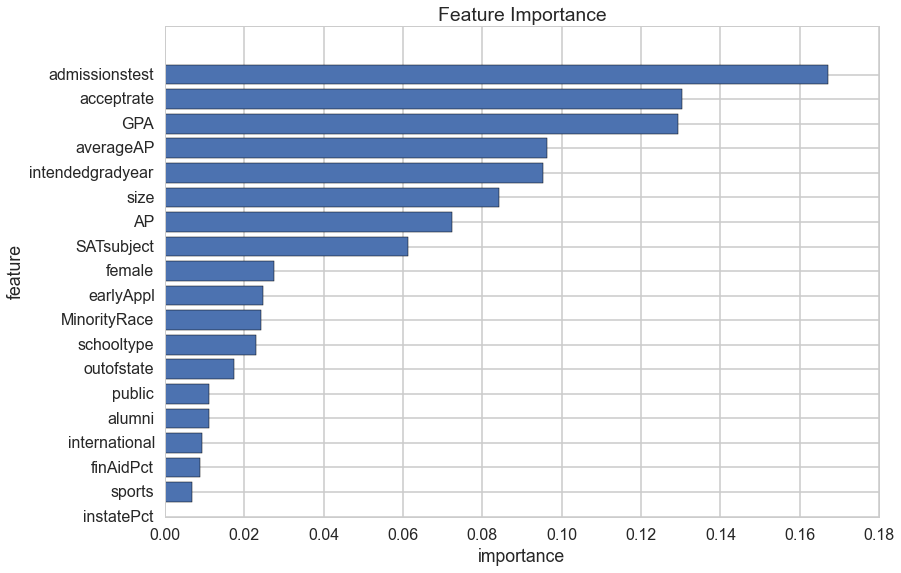

In [35]:
# create dictionary of feature importances
feature_importance = {}
for i in range(len(dfpredict.columns)):
    feature_importance[dfpredict.columns[i]] = clf.feature_importances_[i]
# plot sorted importances
plt.barh(range(len(dfpredict.columns)),sorted(feature_importance.values()), align="center")
plt.ylim([0,20])
plt.yticks(range(len(dfpredict.columns)), sorted(feature_importance,key=feature_importance.get))
plt.ylabel("feature")
plt.xlabel("importance")
plt.title("Feature Importance")
plt.show()

### Decision Tree

Below is a decision tree classifier. Intuitively I think this should be worse than the random forest, because in some sense a decision tree is just a subset of a random forest. 

In [36]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
predicted = dt.predict(X_validate)
metrics.accuracy_score(y_validate, predicted)

0.66215199398043645

This one got us only 65% accuracy, so again significantly worse than the random forest. So at this stage, random forest is still the best!

### Linear SVM

Last one. Let's try Linear SVM. 

In [19]:
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV
svmm = LinearSVC(loss="hinge")
C = [0.001,0.01,0.1,1,10,100,1000]
fitmodel = GridSearchCV(svmm, param_grid={"C":C}, cv=5, scoring="accuracy")
fitmodel.fit(X_train, y_train)
fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_, fitmodel.grid_scores_

svm_best=LinearSVC(loss="hinge",C=fitmodel.best_params_['C'])
svm_best.fit(X_train, y_train)
ypred_svm = svm_best.predict(X_test)
metrics.accuracy_score(ypred_svm, y_test)

0.61677322301617155

This one is our worst predictor, giving only 62% accuracy. Looks like random forest is the one!

### Dropping `Intended Graduation Year` As A Predictor

Given that our data stretches back only as far as 2009, it is worth seeing whether dropping `intendedgradyear` as a predictor will help. This assumes that the admissions regime at all of the top 25 colleges has not drastically changed over the last few years. 

In [20]:
dfpredict1 = dfpredict.drop("intendedgradyear",axis=1)
X = imp.transform(dfpredict1)
y = dfresponse
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
ntdict = {}
for nt in [5,10,25,50,100,250,500,1000]:
    clf = RandomForestClassifier(n_estimators=nt,criterion="gini")
    clf.fit(X_train,y_train)
    predicted = clf.predict(X_test)
    ntdict[nt] = metrics.accuracy_score(y_test, predicted)
print ntdict
best_nt = max(ntdict, key=ntdict.get)
print best_nt, ntdict[best_nt]
clf = RandomForestClassifier(n_estimators=nt)
clf.fit(X_train,y_train)
predicted = clf.predict(X_test)

{100: 0.74050394885295223, 5: 0.70816096276795792, 1000: 0.73975178638585937, 10: 0.72132380594208345, 50: 0.73486273034975558, 500: 0.74200827378713807, 25: 0.74200827378713807, 250: 0.74050394885295223}
500 0.742008273787
